## Post processing of the one sided diffusor case 

#### 1 General variables

In [216]:
# file path
path = '../test_cases/kOmegaSSTIDDES/run/kOmegaSSTIDDES_transient/steadyState' #steady 6000

# time to which case was solved used for the pressure difference 
last_time = 6000

# number of iterations at which the wall shear stress is analyzed
time = 6000


# angle of the ramp
angle = 20

# density of the airflow 
rhoL = 1.225

#### 1.1 Used Libaries

In [217]:
# loading libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### 2 Functions

#### 2.1 Function to plot residuals

In [218]:
def residuals():
    # column names 
    colnames = [
        "Time", "U_solver", "Ux_initial", "Ux_final", "Ux_iters",
        "Uy_initial", "Uy_final", "Uy_iters","Uz_initial", "Uz_final", "Uz_iters", "U_converged",
        "k_solver", "k_initial", "k_final", "k_iters", "k_converged",
        "omega_solver", "omega_initial", "omega_final", "omega_iters", "omega_converged",
        "p_solver", "p_initial", "p_final", "p_iters", "p_converged"
    ]


    # plotting 
    plt.figure(figsize=(12, 6))
    filepath = str(path) + '/postProcessing/solverInfo/0/solverInfo.dat'
        
        # reading data
    df = pd.read_csv(filepath, sep=r'\s+', skiprows=2, names=colnames)
    
        
    plt.plot(df["Time"], df["Ux_initial"], label="Ux_initial")
    plt.plot(df["Time"], df["Uy_initial"], label="Uy_initial")
    plt.plot(df["Time"], df["Uz_initial"], label="Uz_initial")
    plt.plot(df["Time"], df["k_initial"], label="k_initial")
    plt.plot(df["Time"], df["p_initial"], label="p_initial")
    plt.plot(df["Time"], df["omega_initial"], label="omega_initial")
        
    plt.xlabel("Time")
    plt.ylabel("Initial residuals (log)")
    plt.title(f"Initial residuals")
    plt.yscale('log')
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.xlim(0, last_time)

    # showing layout
    plt.tight_layout()
    plt.show()

#### 2.2 Function to plot and create tables of the wall shear stress along the lower wall

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def wss_low(x_targets):
    # column names 
    colnames = [
        "x", "y", "z", 
        "wallShearStress_x", "wallShearStress_y", "wallShearStress_z", 
        "area_x", "area_y", "area_z"
    ]

    # file path
    filepath = Path(path) / "postProcessing/samples" / str(time) / "wallShearStress_lowerWall.raw"

    # read data
    df = pd.read_csv(filepath, sep=r'\s+', skiprows=2, names=colnames)

    data_pairs = []

    for i, row in df.iterrows():
        x = row["x"]
        area = np.array([row["area_x"], row["area_y"], row["area_z"]])
        norm = np.linalg.norm(area)
        area_normalized = area / norm if norm != 0 else area

        ez = np.array([0, 0, 1])  # wall tangential direction
        cross_prod = np.cross(area_normalized, ez)

        shear = np.array([
            row["wallShearStress_x"], 
            row["wallShearStress_y"], 
            row["wallShearStress_z"]
        ])

        scalar_product = np.dot(shear, cross_prod)

        # WSS in [Pa]
        wss_value = rhoL * scalar_product

        data_pairs.append((x*1000, wss_value))

    # Sort by x and plot
    data_pairs.sort()
    x_vals, wss_vals = zip(*data_pairs)

    # interpolation
    interpolated = np.interp(x_targets, x_vals, wss_vals)


    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, wss_vals, label='Wall shear stress (tangential)', color='blue')
    plt.xlabel("x-position in mm")
    plt.ylabel("Wall shear stress [Pa]")
    plt.title("Tangential wall shear stress along lower wall")
    plt.xlim(0,400)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return DataFrame
    return pd.DataFrame({'x': x_targets, 'wss in Pa': interpolated})




#### 2.3 Function to plot the wall shear stress along the upper wall 

In [220]:
def wss_upperWall(file_path):
    data_wss_upperWall = []

    with open(file_path, 'r') as f:
        for line in f:
            if line.strip().startswith('#') or not line.strip():
                continue

            parts = line.strip().split()
            if len(parts) >= 9:
                x = float(parts[0])

                area = np.array([
                    float(parts[6]),
                    float(parts[7]),
                    float(parts[8])
                ])
                
                wss_x = float(parts[3])
                
                # openFoam wss in m²/s² needs multiplikation with rho to match experiment
                wss = rhoL*wss_x
                data_wss_upperWall.append((x, wss))

    # sorting
    data_wss_upperWall.sort(key=lambda pair: pair[0])
    return sorted(data_wss_upperWall, key=lambda pair: pair[0])


def plot_wss_upperWall():
    plt.figure(figsize=(10, 5))
        
    # choosing file path
    file_path = (
        str(path) + "/postProcessing/samples/" + str(time) + "/wallShearStress_upperWall.raw"
    )

    data_wss_upperWall = process_file(file_path)
    x_vals = [pair[0] for pair in data_wss_upperWall]
    scalar_vals = [pair[1] for pair in data_wss_upperWall]

    plt.plot(x_vals, scalar_vals)
        
    plt.title('wall shear stresses at the upper wall')
    plt.xlabel('global x value in mm ')
    plt.ylabel('wall shear stress in Pa')
    plt.xlim(-0.3, 2)
    #plt.ylim(-1, 0.3)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

#### 2.4 Function to calculate the pressure difference

In [221]:
def delta_p(file_path):
    data_pairs = []

    with open(file_path, 'r') as f:
        for line in f:
            if line.strip().startswith('#') or not line.strip():
                continue

            parts = line.strip().split()

            time = float(parts[0])

            # using the absolute value of p_inlet as delta_p
            delta_p = np.array(abs(float(parts[1])))

            data_pairs.append((time, delta_p))
    return data_pairs

def plot_delta_p():
    plt.figure(figsize=(10, 5))  
  
    file_path = (
        str(path) + "/postProcessing/delta_p:pInlet/0/surfaceFieldValue.dat"
    )

    data_pairs = delta_p(file_path)
    x_vals = [pair[0] for pair in data_pairs]
    scalar_vals = [pair[1] for pair in data_pairs]

    plt.plot(x_vals, scalar_vals)
        
    plt.title('Pressure difference over the diffusor')
    plt.xlabel('time')
    plt.ylabel('absolute value of the pressure in m²/s²')
    plt.xlim(0, last_time)
    #plt.ylim(-0.5, 0.5)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



## 3 Plots and tables 

#### 3.1 Plot of the residuals 

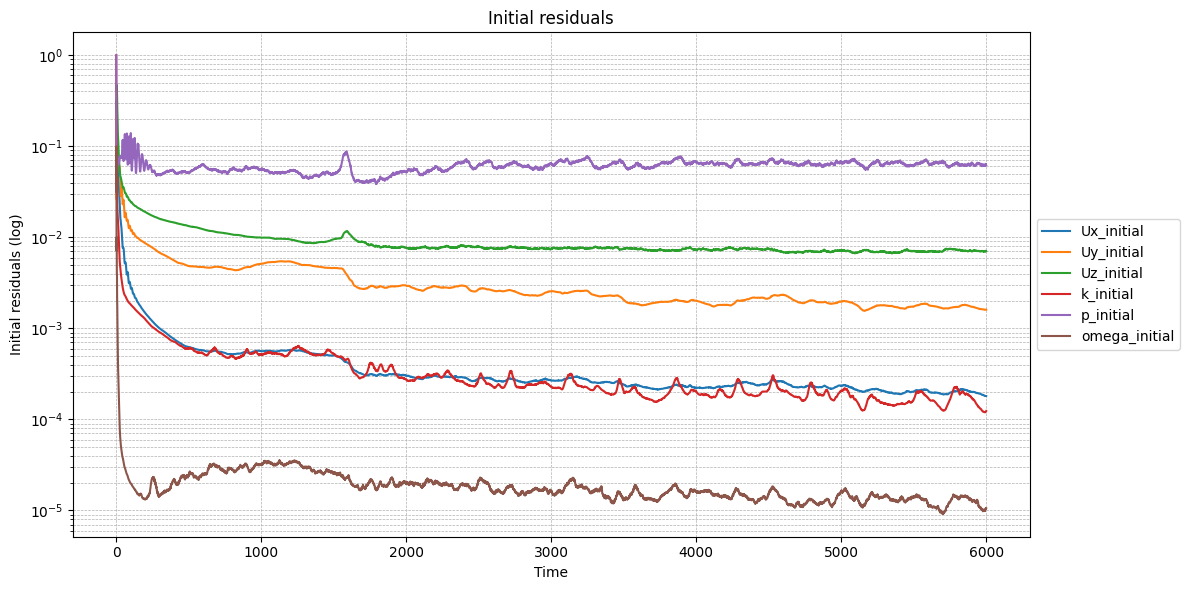

In [222]:
residuals()

#### 3.2 Plot of the wall shear stress along the lower wall 

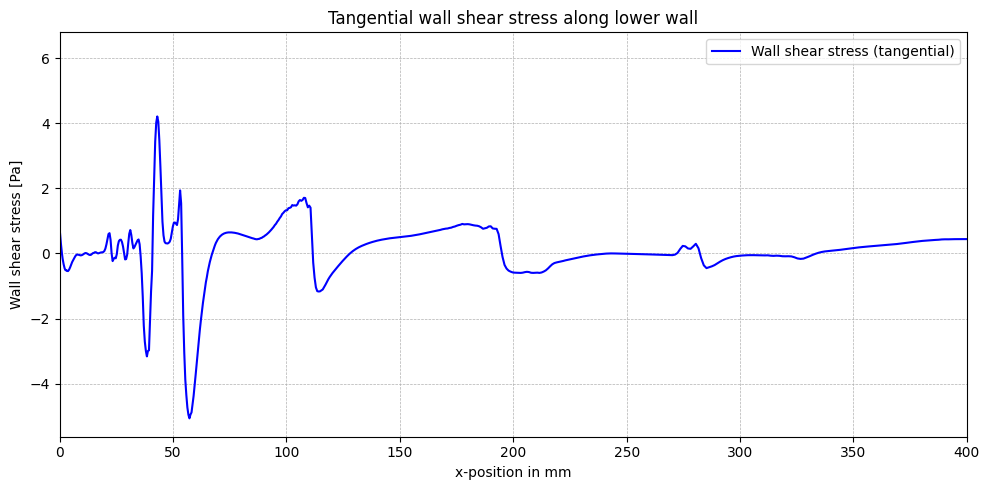

,x,wss in Pa
0,82,0.537953
1,122,-0.456687
2,162,0.636689
3,202,-0.593185
4,242,0.001187
5,282,0.074156
6,386,0.416672


In [223]:
wss_low([82, 122, 162, 202, 242, 282, 386]) # array of x values in mm

#### 3.5 Plot of the wall shear stress along the upper wall (sample doesnt exist jet)

/tmp/ipykernel_113253/2089511393.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


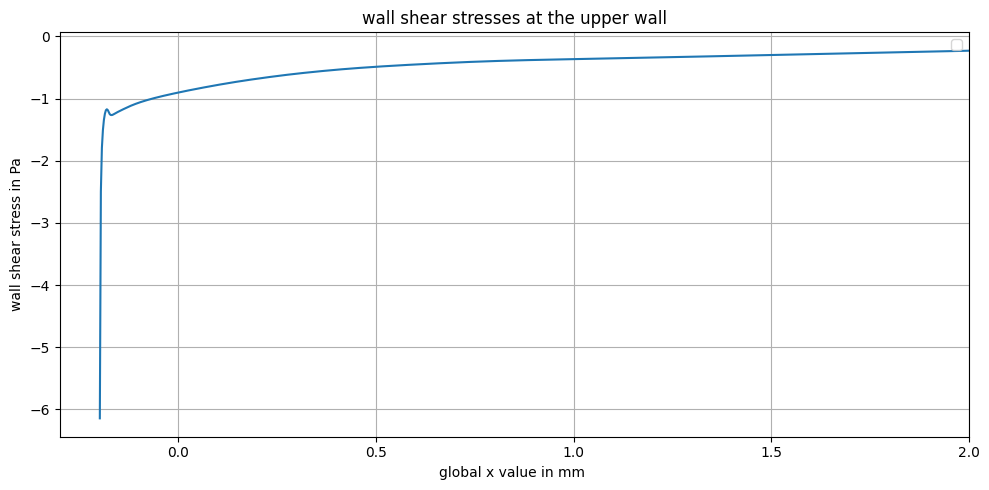

In [224]:
plot_wss_upperWall()

#### 3.6 Plot of the pressure differnce over the diffusor

/tmp/ipykernel_113253/152857264.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


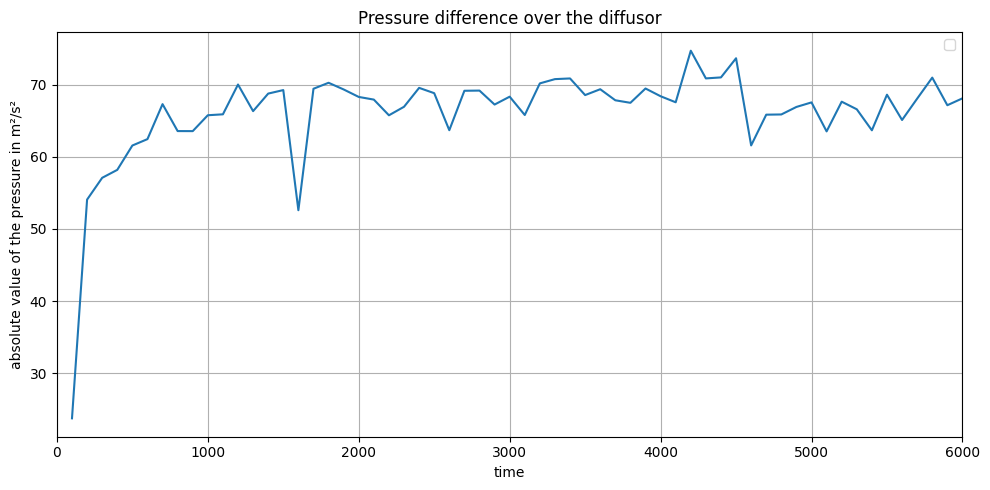

In [225]:
plot_delta_p()